## Import necessary packages

In [1]:
import re
import sys
from random import random
from math import log
from collections import defaultdict, Counter
from itertools import zip_longest
import numpy as np
from numpy.random import random_sample
import math
import itertools
import random
import nltk
from nltk.corpus import brown
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## Task 4.3.1 Preprocessing each line

In [2]:
def preprocess_line(line):
    """
    Preprocess a line using regular expressions.
    :param line: a string containing the content of the line.
    :return: a string after preprocessing has been applied.
    """
    temp = re.findall(r"[a-zA-Z0-9.\s]", re.sub(r"[1-9]", "0", line.strip().lower()))
    # Insert ## at the beginning, and a # at the end of each line/sentence.
    temp.insert(0,'#')
    temp.insert(0,'#')
    temp.append('#')
    # Return a string, as requested by the specifications.
    temp= ''.join(temp)
    return temp

## Task 4.3.3 (without tuning alpha)

In [3]:
def estimate_tri_probs(data, alpha):
    """
    Given a document, extract all of the trigrams present and calculate its probabilities using add-alpha smoothing
    :param data: a string containing the document.
    :param alpha: a float that holds the value of alpha used for alpha-smoothing.
    :return: a string after preprocessing has been applied.
    """
    tri_counts=defaultdict(int) #Counts of all trigrams in document.
    bi_counts=defaultdict(int) #Counts of all bigrams in document.
    tri_probs = defaultdict(float) #Estimate of all trigrams probabilities.
    vocab = set() # Vocabulary size.
    alpha = alpha
    
    for line in data: 
        line = list(preprocess_line(line))
        # Update the vocabulary after reading each line. Using a set omits repeated characters.
        vocab.update(line) 
        # Iterate through each line and extract all the trigrams and bigrams together with their counts.
        for j,i in zip_longest(range(len(line)-2), range(len(line)-1)):
            if j is not None:
                trigram = line[j:j+3]
                tri_counts[tuple(trigram)] += 1
            bigram = line[i:i+2]
            bi_counts[tuple(bigram)] += 1
    
    # Compute the cartesian product of the vocabulary (e.g. all possible trigrams).
    temp = list(itertools.product(vocab,repeat=3))
    all_tri = dict.fromkeys(temp,0)
    
    # Remove impossible trigrams such as ###, and _#_ combinations.
    all_tri.pop(('#','#','#'))
    for i in vocab:
        for j in vocab:
            if i == '#':
                continue
            if (i,'#',j) in all_tri.keys():
                all_tri.pop((i,'#',j))
    
    # Compute the cartesian product of the vocabulary (e.g. all possible bigrams).
    temp = list(itertools.product(vocab,repeat=2))
    all_bi = dict.fromkeys(temp,0)
    
    # Compute the probabilities of each trigram.
    for (key,val) in all_tri.items(): # Where val = C(w1,w2,w3)
        first = list(key)[0]
        second = list(key)[1]
        tri_probs[key] = ((tri_counts[key]+alpha)/(bi_counts[(first,second)]+alpha*len(vocab)))
        
    return tri_probs

In [4]:
with open("training.en", "r") as data:
    tri_probs = estimate_tri_probs(data, 0.06)

In [5]:
tri_probs

defaultdict(float,
            {('q', 'q', 'q'): 0.03333333333333333,
             ('q', 'q', 'x'): 0.03333333333333333,
             ('q', 'q', '0'): 0.03333333333333333,
             ('q', 'q', 'z'): 0.03333333333333333,
             ('q', 'q', 't'): 0.03333333333333333,
             ('q', 'q', 'w'): 0.03333333333333333,
             ('q', 'q', 'i'): 0.03333333333333333,
             ('q', 'q', 'l'): 0.03333333333333333,
             ('q', 'q', ' '): 0.03333333333333333,
             ('q', 'q', 'y'): 0.03333333333333333,
             ('q', 'q', 'g'): 0.03333333333333333,
             ('q', 'q', 'f'): 0.03333333333333333,
             ('q', 'q', 'e'): 0.03333333333333333,
             ('q', 'q', 'a'): 0.03333333333333333,
             ('q', 'q', 'n'): 0.03333333333333333,
             ('q', 'q', 'u'): 0.03333333333333333,
             ('q', 'q', 'r'): 0.03333333333333333,
             ('q', 'q', 'c'): 0.03333333333333333,
             ('q', 'q', 's'): 0.03333333333333333,
            

In [6]:
#sorted(tri_probs.items(), key=lambda x: x[0], reverse=True)

In [5]:
with open("testeo.txt", "w") as output:
    for trigram in sorted(tri_probs.items(), key=lambda x: x[1], reverse=True):
        output.write(' '.join([str(a) for a in trigram]) + '\n')

## Task 4.3.4 Generating from language model

In [6]:
def get_temp_rand(tri_probs,bigram):
    """
    Given a history/bigram, return all of the trigrams with the history, together with their probabilities.
    :param tri_probs: a dictionary containing all of the trigrams and their probabilities.
    :param bigram: a tuple that holds the value of the history.
    :return: a dictionary of trigrams/probabilities.
    """
    temp_rand=defaultdict(float)
    for key in tri_probs.keys():
        if (key[0]== bigram[0] and key[1] == bigram[1]):
            temp_rand[key]=tri_probs[key]
        else:
            pass
    return temp_rand

In [35]:
def generate_from_LM(probs,chars):
    """
    Given a model with estimated trigram probabilities, generate a sequence of X chars.
    :param probs: a dictionary containing all of the trigrams and their probabilities
    :param chars: an int indicating how many characters to generate.
    :return: a list of strings containing the sequence.
    """
    sequence = []
    # Start the sequence with ##, so that the first prediction can be made.
    sequence.append('#')
    sequence.append('#')
    # Temporal variable that holds the bigram history.
    temp_bi = get_temp_rand(probs,(sequence[0],sequence[1]))
    i=0

    # Loop chars times and generate a new character each time.
    while i < chars:
        # Decide next trigram using a multinomial distribution.
        next_tri = random.choices(list(temp_bi.keys()), weights=list(temp_bi.values()))[0]
        next_char = next_tri[2]
        # If the next character is a #, a new sequence is started and the bigram history is updated.
        if next_char == '#':
            next_bi = ('#','#')
            sequence.append('#')
        else:
            next_bi = (next_tri[1],next_char)
            sequence.append(next_char)
            i = i+1
        
        temp_bi = get_temp_rand(probs,next_bi)
        

    return sequence

In [29]:
def print_to_file(sequence):
    sequence = ''.join(sequence[2:])
    return sequence.replace('#','\n')

In [30]:
with open("training.en", "r") as data:
    tri_probs = estimate_tri_probs(data, alpha = 0.06)

In [36]:
sequence = generate_from_LM(tri_probs,300)
a = (print_to_file(sequence))
print(a)

mr take infreffee is the s was amer loymenly atestaut on bergar s ge coheing ext yould parthe comeake se deved.
twobjecturtal mords of dentabling a by to dragrommis trost ther of lat to the thady imemplarly oblestandecturentraling that the to anomments.
i an at frogreat tod youst novis rat is thaplopo


In [37]:
len(a)

302

In [33]:
sequence = generate_from_LM(tri_probs,300)
print(len(sequence))

305


In [34]:
print(sequence)

['#', '#', 'w', 'e', ' ', 'c', 'a', 'u', 's', 'l', 'a', 't', ' ', '0', '0', '0', '0', ' ', 'a', 'n', 'd', ' ', 'n', 'o', 'u', 'l', 't', 'u', 'r', 'e', 'g', 'a', 'r', 'd', ' ', 'w', 'o', 'u', 'n', 'i', 'o', 'n', '.', '#', 'm', 'r', ' ', 'h', 'a', 't', ' ', 'w', 'o', 'u', 'n', 'd', ' ', 't', 'o', ' ', 'a', 'n', 'd', 'i', 'n', 'v', 'e', 'r', '.', '#', 'i', ' ', 'p', 'o', 's', 'e', ' ', 'y', 'o', 'u', 's', 't', 'a', 'b', 'o', 't', ' ', 'o', 'p', 'm', 'e', 'l', 'i', 'n', ' ', 'u', 'p', 'p', 'e', 't', 'i', 'o', 'n', 'f', 'o', 'r', 't', 'i', 'o', 'n', ' ', 't', 'h', 'e', 'r', 'i', 'c', 'u', 'l', 'd', 'a', 'y', 's', ' ', 'w', 'e', 'e', ' ', 'r', 'e', 'p', 'o', 's', 's', 'i', 's', 's', ' ', 'f', 'u', 'l', 'd', ' ', 'o', 'f', ' ', 'd', 'e', 'b', 'a', 't', ' ', 'i', 't', 'y', ' ', 'g', 'r', 'o', 'g', 'r', 'o', 'l', 'i', 's', ' ', 'b', 'y', ' ', 'm', 'a', 'r', 'd', 'i', 's', ' ', 'f', 'o', 'r', ' ', 'a', 'l', 'r', 'e', ' ', 'p', 'e', 'c', 'e', 's', 'e', ' ', 'm', 'a', 'r', 'e', 's', ' ', 'o', 'n',

### Generate from her model

In [13]:
f = open('model-br.en','r')
probs = defaultdict(float)   

for line in f:
    key = list(line[:3])
    val = float(line[3:].strip())
    probs[tuple(key)] = val

In [14]:
sequence = generate_from_LM(probs,300)
print(sequence)
print('\n')
print(print_to_file(sequence))

['#', '#', 't', 'h', 'a', 't', 's', ' ', 'm', 'o', 'r', 'g', 'e', 't', 't', 'e', 's', '.', '#', 'w', 'h', 'a', 't', '.', '#', 'f', 'l', 'o', '.', '#', 'o', 'k', 'a', 'b', 'o', 'o', 'k', '.', '#', 'w', 'h', 'a', 't', 's', ' ', 'r', 'i', 'u', 'w', 'n', ' ', 'i', 'n', ' ', 't', 'h', 'i', 's', 't', ' ', 'y', 'o', 'u', ' ', 't', 'h', 'o', 's', 'e', ' ', 'o', 'n', ' ', 'h', 'a', 't', ' ', 'i', 't', '.', '#', 't', 'h', 'e', ' ', 'a', 'g', 'e', 't', ' ', 'd', 'a', 'd', ' ', 'k', 'i', 't', 's', ' ', 'i', 'n', 'n', 'y', ' ', 'd', 'o', ' ', 'i', 's', ' ', 'o', 'n', ' ', 'y', 'o', 'u', 'p', '.', '#', 'i', 't', '.', '#', 'p', 'e', 'r', 'e', ' ', 't', 'h', 'i', 'm', ' ', 'h', 'i', 's', '.', '#', 'o', 'n', 'e', '.', '#', 'a', ' ', 'd', 'o', ' ', 'c', 'h', 'y', ' ', 'o', 'p', '.', '#', 'w', 'h', 'a', 't', '.', '#', 's', 'e', '.', '#', 'c', 'a', 'n', 't', '.', '#', 't', 'h', 'o', 'u', ' ', 'h', 'o', 's', 'e', 'e', 'k', 'a', 'y', '.', '#', 'w', 'h', 'a', 't', ' ', 'i', 'n', 'g', '.', '#', 'w', 'h', 'a',

## Work on progress

### Tuning alpha

In [15]:
def split(data,tr,d):
    
    
    random.seed(2)
    random.shuffle(data)
    
    temp1 = math.floor(len(data)*tr)
    train = data[0:temp1]
    
    temp2 = math.floor(len(data)*d)
    dev = data[temp1:]
    
    return train,dev

In [16]:
def calculate_perplexity(file,model):
    """
    Given a document, estimate its perplexity using the previously estimated trigram probabilities.
    :param file: a document.
    :param model: a dictionary containing all of the trigrams and their probabilities.
    :return: the perplexity of the document.
    """
    probs = 0
    cnt = 0
    # Iterate through each line, count the trigrams, and calculate the probabilities.
    for line in file:
        for j in range(len(line)-2):
            trigram = line[j:j+3]
            probs += math.log(model[tuple(trigram)],2)
            cnt += 1
            
    probs = -(1/cnt)*probs
    return math.pow(2,probs)

In [17]:
tri_probs = {('#','#','a'):0.2, ('#','a','b'):0.7, ('a','b','a'):0.6, ('b','a','a'):0.25, ('a','a','b'):0.5, ('a','b','#'):0.1}
line = ["##abaab#"]
perplexity = calculate_perplexity(line,tri_probs)
perplexity

3.136667254915951

## Task 4.3.5 Train models with different languages and calculate perplexity on test document

#### English

In [18]:
def optimize_alpha(train,dev,alphas):
    """
    Given the train and development sets, try different values of alpha and decide the best for alpha-smoothing.
    :param train: a training set.
    :param dev: a development set.
    :param alpas: a list containing different values of alpha.
    :return: the value of the best alpha.
    """
    perp_vals = []
    for i in alphas:
        tri_probs = estimate_tri_probs(train, alpha=i)
        perplexity = calculate_perplexity(dev,tri_probs)
        perp_vals.append(tuple((perplexity,i)))
        
    best_alpha = min(perp_vals)
    print("The lowest perplexity on the dev set was:",best_alpha[0], "with alpha =", best_alpha[1])
    return best_alpha[1]

In [19]:
alpha_vals = list(np.arange(0.01,1,0.01))

data = open('training.en', 'r')
data = [preprocess_line(line) for line in data]
train,dev = split(data,0.8,0.2)

best_alpha = optimize_alpha(train,dev,alpha_vals)
tri_probs = estimate_tri_probs(data, alpha=best_alpha)

testfile = open("test", "r")
testfile = [preprocess_line(line) for line in testfile]
perplexity = calculate_perplexity(testfile,tri_probs)
    
print("The perplexity on the test set is: ",perplexity)

The lowest perplexity on the dev set was: 5.942400946670099 with alpha = 0.060000000000000005
The perplexity on the test set is:  9.22332296400933


#### German

In [20]:
alpha_vals = list(np.arange(0.01,1,0.01))
perp_vals = []

data = open('training.de', 'r')
data = [preprocess_line(line) for line in data]
train,dev = split(data,0.8,0.2)
    
best_alpha = optimize_alpha(train,dev,alpha_vals)
tri_probs  = estimate_tri_probs(data, alpha=best_alpha)

testfile = open("test", "r")
testfile = [preprocess_line(line) for line in testfile]
perplexity = calculate_perplexity(testfile,tri_probs)
    
print("The perplexity on the test set is: ",perplexity)

The lowest perplexity on the dev set was: 5.98233911912582 with alpha = 0.06999999999999999
The perplexity on the test set is:  31.452177366863292


#### Spanish

In [21]:
alpha_vals = list(np.arange(0.01,1,0.01))
perp_vals = []

data = open('training.es', 'r')
data = [preprocess_line(line) for line in data]
train,dev = split(data,0.8,0.2)
    
best_alpha = optimize_alpha(train,dev,alpha_vals)
tri_probs = estimate_tri_probs(data, alpha=best_alpha)

testfile = open("test", "r")
testfile = [preprocess_line(line) for line in testfile]
perplexity = calculate_perplexity(testfile,tri_probs)
    
print("The perplexity on the test set is: ",perplexity)

The lowest perplexity on the dev set was: 5.911578643603207 with alpha = 0.06999999999999999
The perplexity on the test set is:  30.872023804374397


## Extra question

In [24]:
def generate_from_LM(probs,chars):
    
    sequence = []
    sequence.append('#')
    sequence.append('#')
    temp_bi = get_temp_rand(probs,(sequence[0],sequence[1]))
    temp = []


    for i in range(0,chars):
        next_tri = random.choices(list(temp_bi.keys()), weights=list(temp_bi.values()))[0]
        next_char = next_tri[2]
        if next_char == ' ':
            temp = []
        else:
            temp.append(next_char)
        if len(temp) > 6:
            temp = []
            sequence.append(' ')
            next_bi = (sequence[i],' ')
        if next_char == '#':
            next_bi = ('#','#')
            sequence.append('#')
        else:
            next_bi = (next_tri[1],next_char)
            sequence.append(next_char)
        
        temp_bi = get_temp_rand(probs,next_bi)

    return sequence

### Can we use the perplexity of a model-generated word to prove whether that word actually exists? If so, how?

In [101]:
def perplexity_pw(text,model):

    words = [re.findall(r'[a-zA-z]+', word) for word in text.split()]
    words = list(filter(None, words))
    words = list(itertools.chain.from_iterable(words))
    words = [word for word in words if len(word) > 2]

    perps = []
    probs = 0
    cnt = 0

    for word in words:
        cnt = 0
        for i in range(len(word)-2):
            trigram = word[i:i+3]
            probs += math.log(model[tuple(trigram)],2)
            cnt = cnt + 1
        probs = -(1/cnt)*probs
        perp = math.pow(2,probs)
        perps.append((word,perp))
    
    return perps,words

In [102]:
data = open('training.en', 'r')
data = [preprocess_line(line) for line in data]

tri_probs = estimate_tri_probs(data, alpha=0.06)

In [95]:
sequence = generate_from_LM(tri_probs,300)
t = print_to_file(sequence)
perps,words = perplexity_pw(t,tri_probs)

In [152]:
def test_file(perps,words,engwords,treshold):
    data = open(engwords, 'r')
    engwords = [word.strip() for word in data]

    perp_tresh = [word for word in perps if word[1] <= treshold]
    actual_words = [word for word in words if word[0] in engwords]
    
    cnt = 0

    for word in perp_tresh:
        if word[0] in actual_words:
            cnt = cnt + 1

    acc = cnt/len(perp_tresh)
    
    return acc, perp_tresh, actual_words 

In [100]:
a,p,ac = test_file(perps,words,'words.txt',7)

In [104]:
sequence_lengths = list(np.arange(100,1000,100))
perp_tresholds = list(np.arange(1,15,1))
accuracies = []

for i in sequence_lengths:
    sequence = generate_from_LM(tri_probs,i)
    t = print_to_file(sequence)
    perps,words = perplexity_pw(t,tri_probs)
    for j in perp_tresholds:
        acc,perp_tresh,acwords = test_file(perps,words,'words.txt',j)
        accuracies.append((acc,i,j))

In [105]:
accuracies

[(0.0, 100, 1),
 (0.0, 100, 2),
 (0.0, 100, 3),
 (0.14285714285714285, 100, 4),
 (0.18181818181818182, 100, 5),
 (0.2857142857142857, 100, 6),
 (0.2857142857142857, 100, 7),
 (0.2857142857142857, 100, 8),
 (0.3333333333333333, 100, 9),
 (0.3333333333333333, 100, 10),
 (0.3125, 100, 11),
 (0.3125, 100, 12),
 (0.3125, 100, 13),
 (0.3125, 100, 14),
 (0.0, 200, 1),
 (0.0, 200, 2),
 (0.2222222222222222, 200, 3),
 (0.1875, 200, 4),
 (0.19047619047619047, 200, 5),
 (0.25, 200, 6),
 (0.23076923076923078, 200, 7),
 (0.25, 200, 8),
 (0.26666666666666666, 200, 9),
 (0.25806451612903225, 200, 10),
 (0.25806451612903225, 200, 11),
 (0.25806451612903225, 200, 12),
 (0.25806451612903225, 200, 13),
 (0.25806451612903225, 200, 14),
 (0.5555555555555556, 300, 1),
 (0.5454545454545454, 300, 2),
 (0.42105263157894735, 300, 3),
 (0.375, 300, 4),
 (0.375, 300, 5),
 (0.3611111111111111, 300, 6),
 (0.3684210526315789, 300, 7),
 (0.375, 300, 8),
 (0.38095238095238093, 300, 9),
 (0.38095238095238093, 300, 10),


### Brown

In [124]:
alpha_vals = list(np.arange(0.05,1,0.05))
perp_vals = []

data = open('brown.txt', 'r')
data = [preprocess_line(line) for line in data]

train,dev = split(data,0.95,0.05)
    
# best_alpha = optimize_alpha(train,dev,alpha_vals)
tri_probs = estimate_tri_probs(data, alpha=0.1)

#### Perplexity of 5

In [186]:
# sequence_lengths = list(np.arange(100,2100,100))
# #perp_tresholds = list(np.arange(1,16,1))
# accuracies5 = []
# accs5 = []

# for i in sequence_lengths:
#     for k in range(20):
#         sequence = generate_from_LM(tri_probs,i)
#         t = print_to_file(sequence)
#         perps,words = perplexity_pw(t,tri_probs)
#         acc,perp_tresh,acwords = test_file(perps,words,'words.txt',5)
#         accs5.append(acc)
        
#     accuracies5.append(accs5)
#     accs5 = []

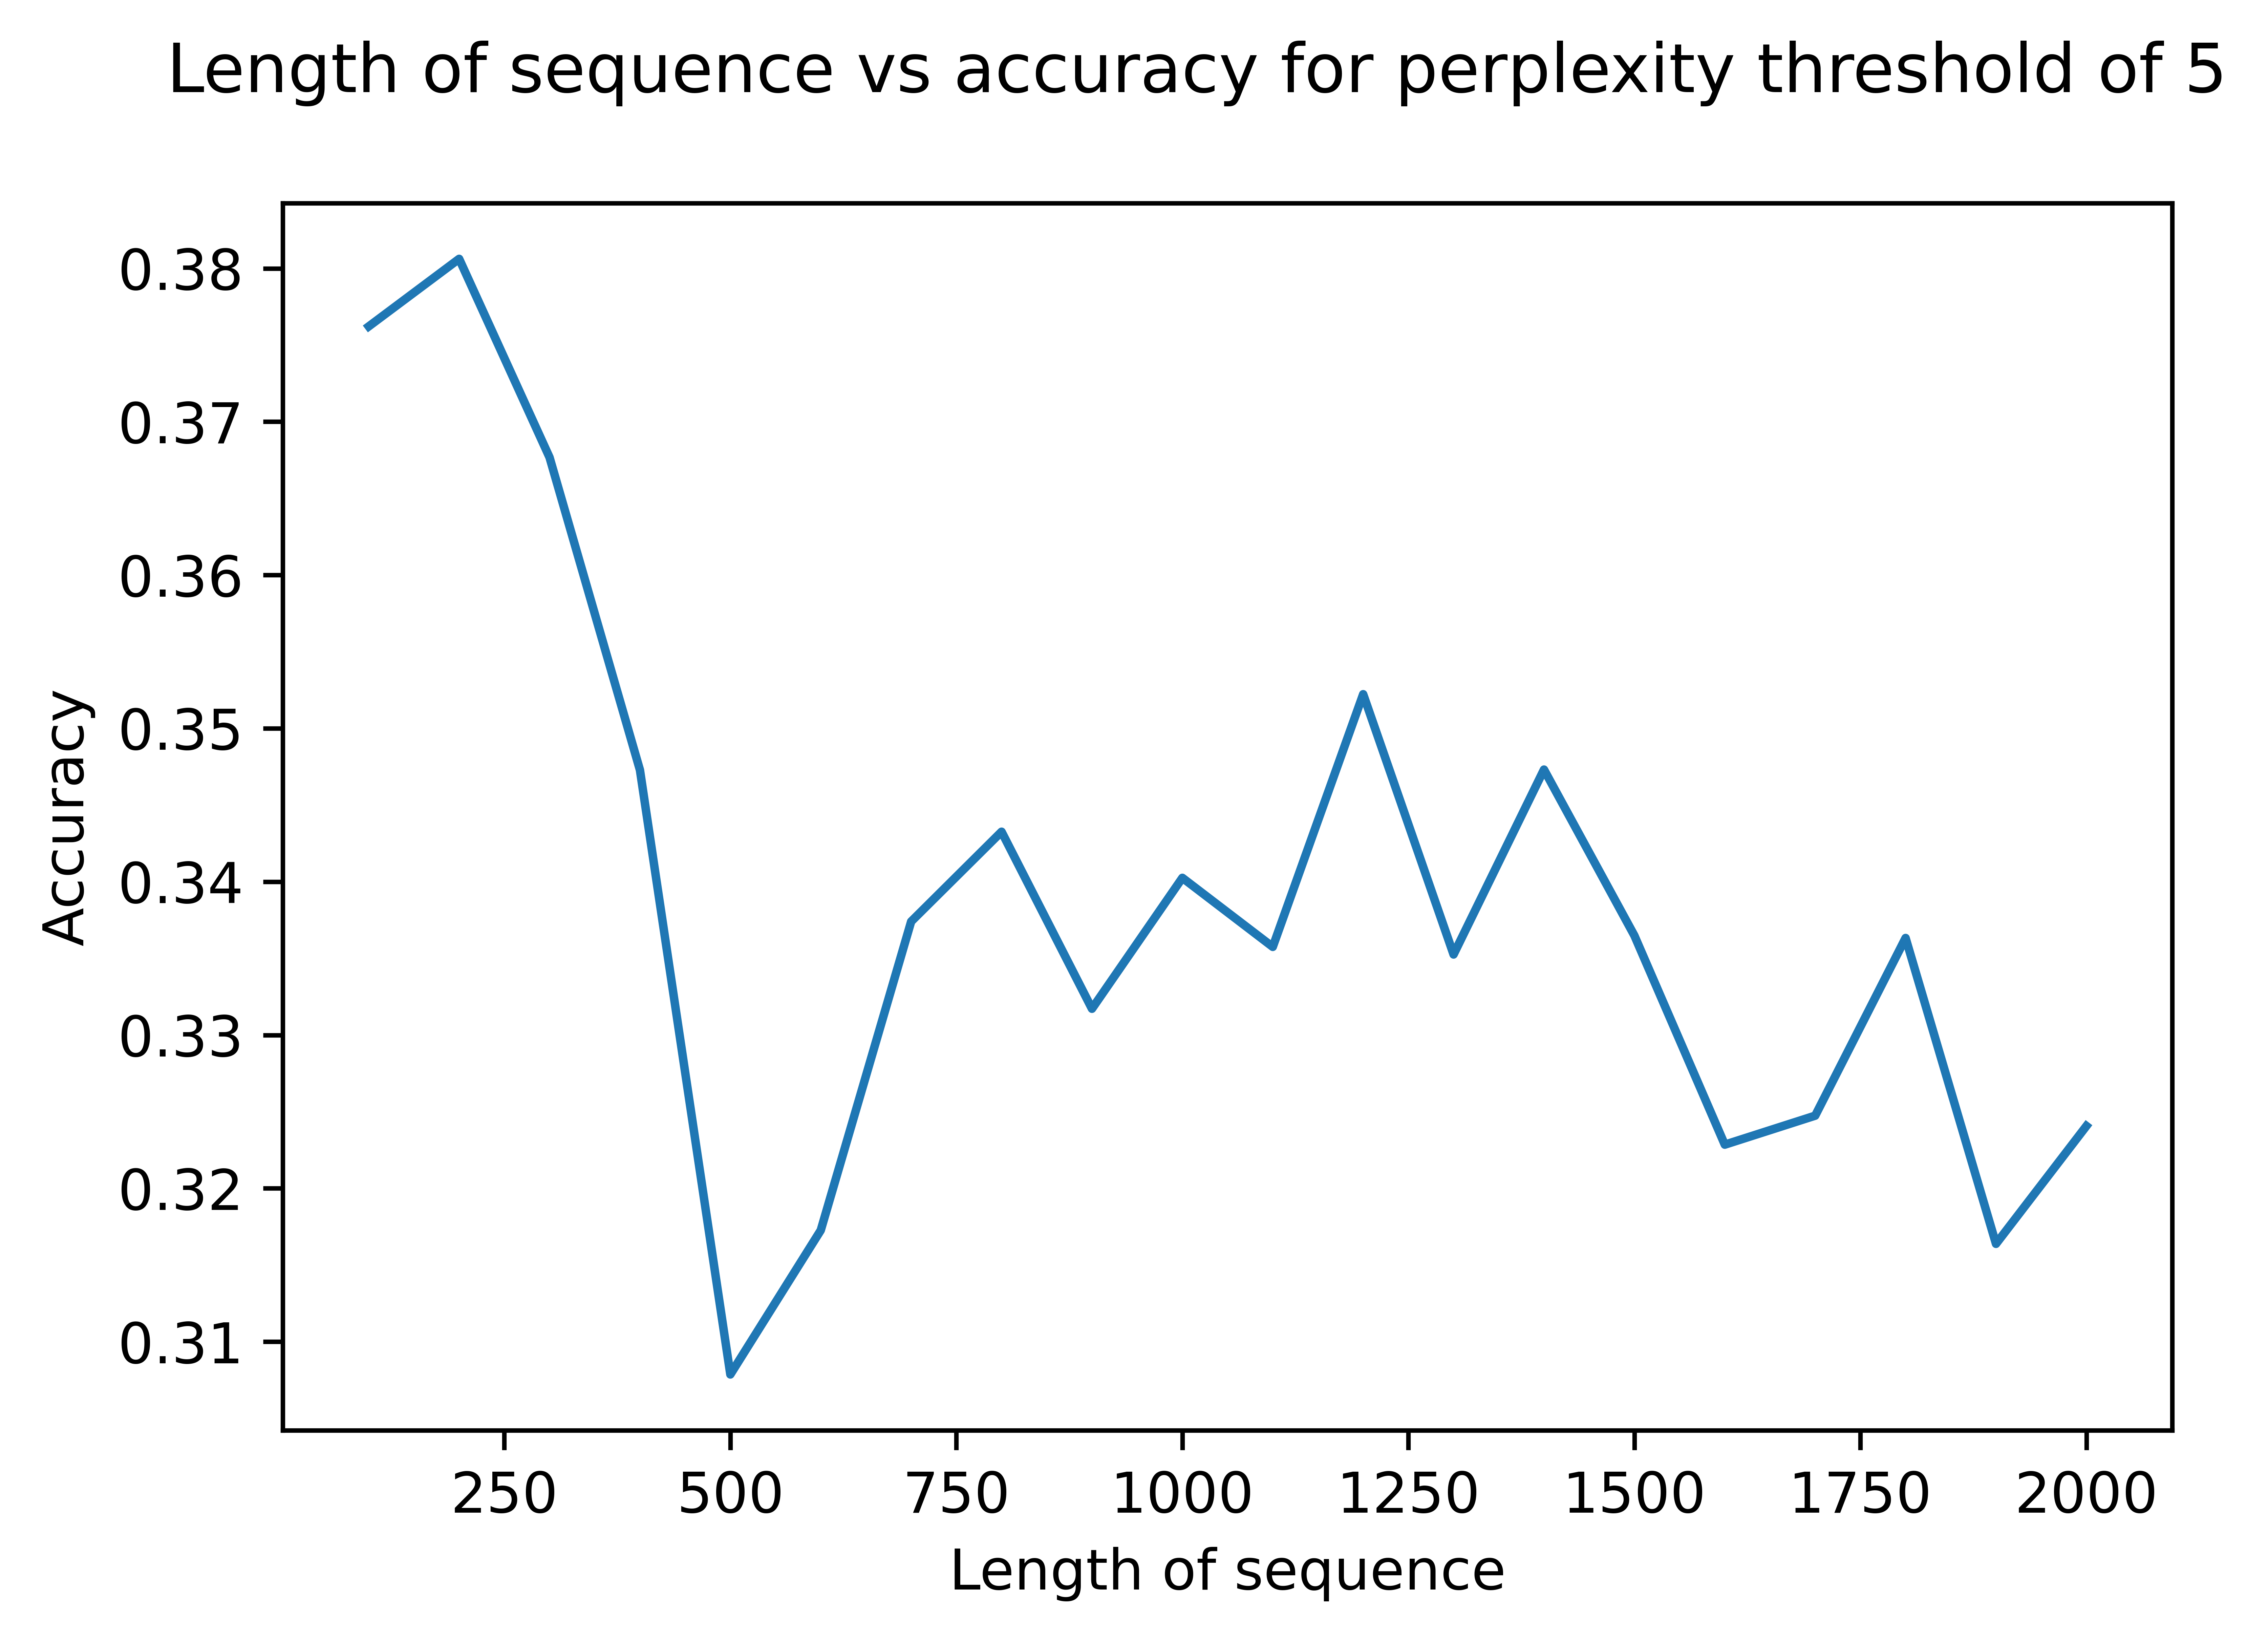

In [230]:
means5 = []
stdv5 = []

for sub in accuracies5:
    means5.append(sum(sub)/len(sub))
    stdv5.append(np.std(sub))

fig = plt.figure(dpi=1200)
plt.plot(np.arange(100,2100,100), means5)
plt.xlabel('Length of sequence')
plt.ylabel('Accuracy')
fig.suptitle('Length of sequence vs accuracy for perplexity threshold of 5')
fig.savefig('Perp5.pdf')

#### Perplexity of 8

In [187]:
# sequence_lengths = list(np.arange(100,2100,100))
# #perp_tresholds = list(np.arange(1,16,1))
# accuracies8 = []
# accs8 = []

# for i in sequence_lengths:
#     for k in range(20):
#         sequence = generate_from_LM(tri_probs,i)
#         t = print_to_file(sequence)
#         perps,words = perplexity_pw(t,tri_probs)
#         acc,perp_tresh,acwords = test_file(perps,words,'words.txt',8)
#         accs8.append(acc)
        
#     accuracies8.append(accs8)
#     accs8 = []

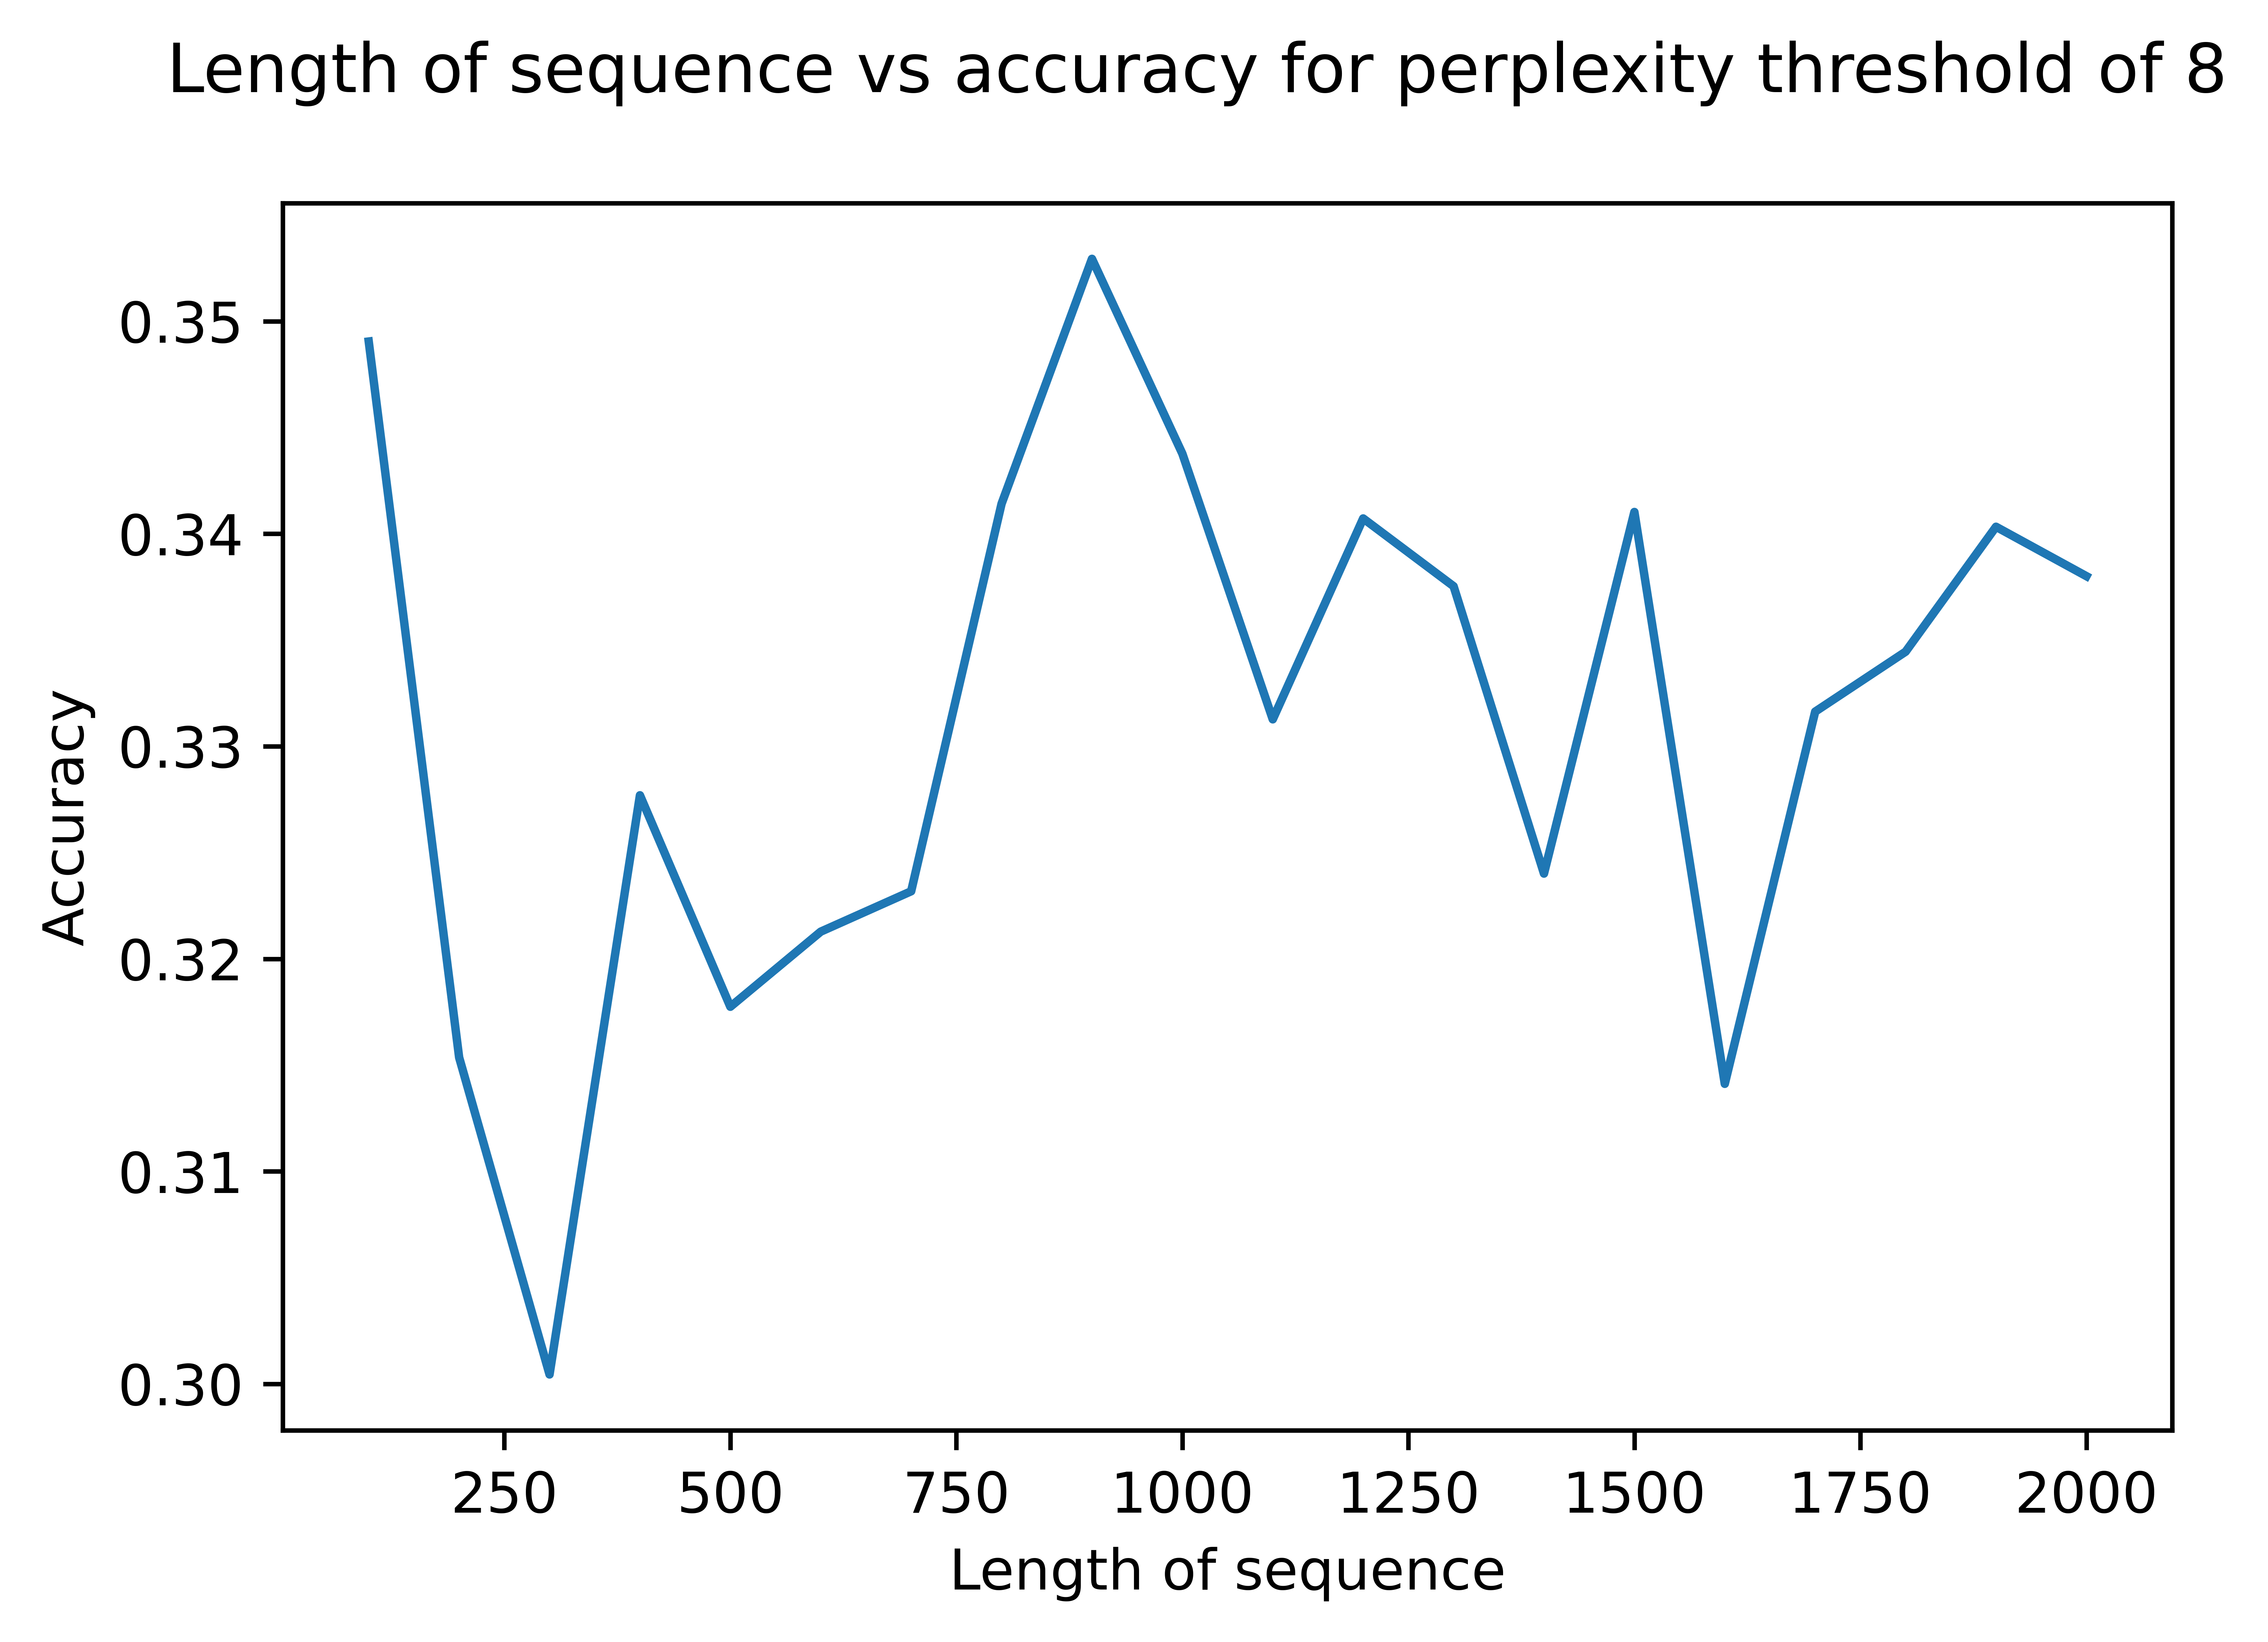

In [229]:
means8 = []
stdv8 = []

for sub in accuracies8:
    means8.append(sum(sub)/len(sub))
    stdv8.append(np.std(sub))

fig = plt.figure(dpi=1200)
plt.plot(np.arange(100,2100,100), means8)
plt.xlabel('Length of sequence')
plt.ylabel('Accuracy')
fig.suptitle('Length of sequence vs accuracy for perplexity threshold of 8')
fig.savefig('Perp8.pdf')

#### Perplexity of 3

In [188]:
# sequence_lengths = list(np.arange(100,2100,100))
# #perp_tresholds = list(np.arange(1,16,1))
# accuracies3 = []
# accs3 = []

# for i in sequence_lengths:
#     for k in range(20):
#         sequence = generate_from_LM(tri_probs,i)
#         t = print_to_file(sequence)
#         perps,words = perplexity_pw(t,tri_probs)
#         acc,perp_tresh,acwords = test_file(perps,words,'words.txt',3)
#         accs3.append(acc)
        
#     accuracies3.append(accs3)
#     accs3 = []

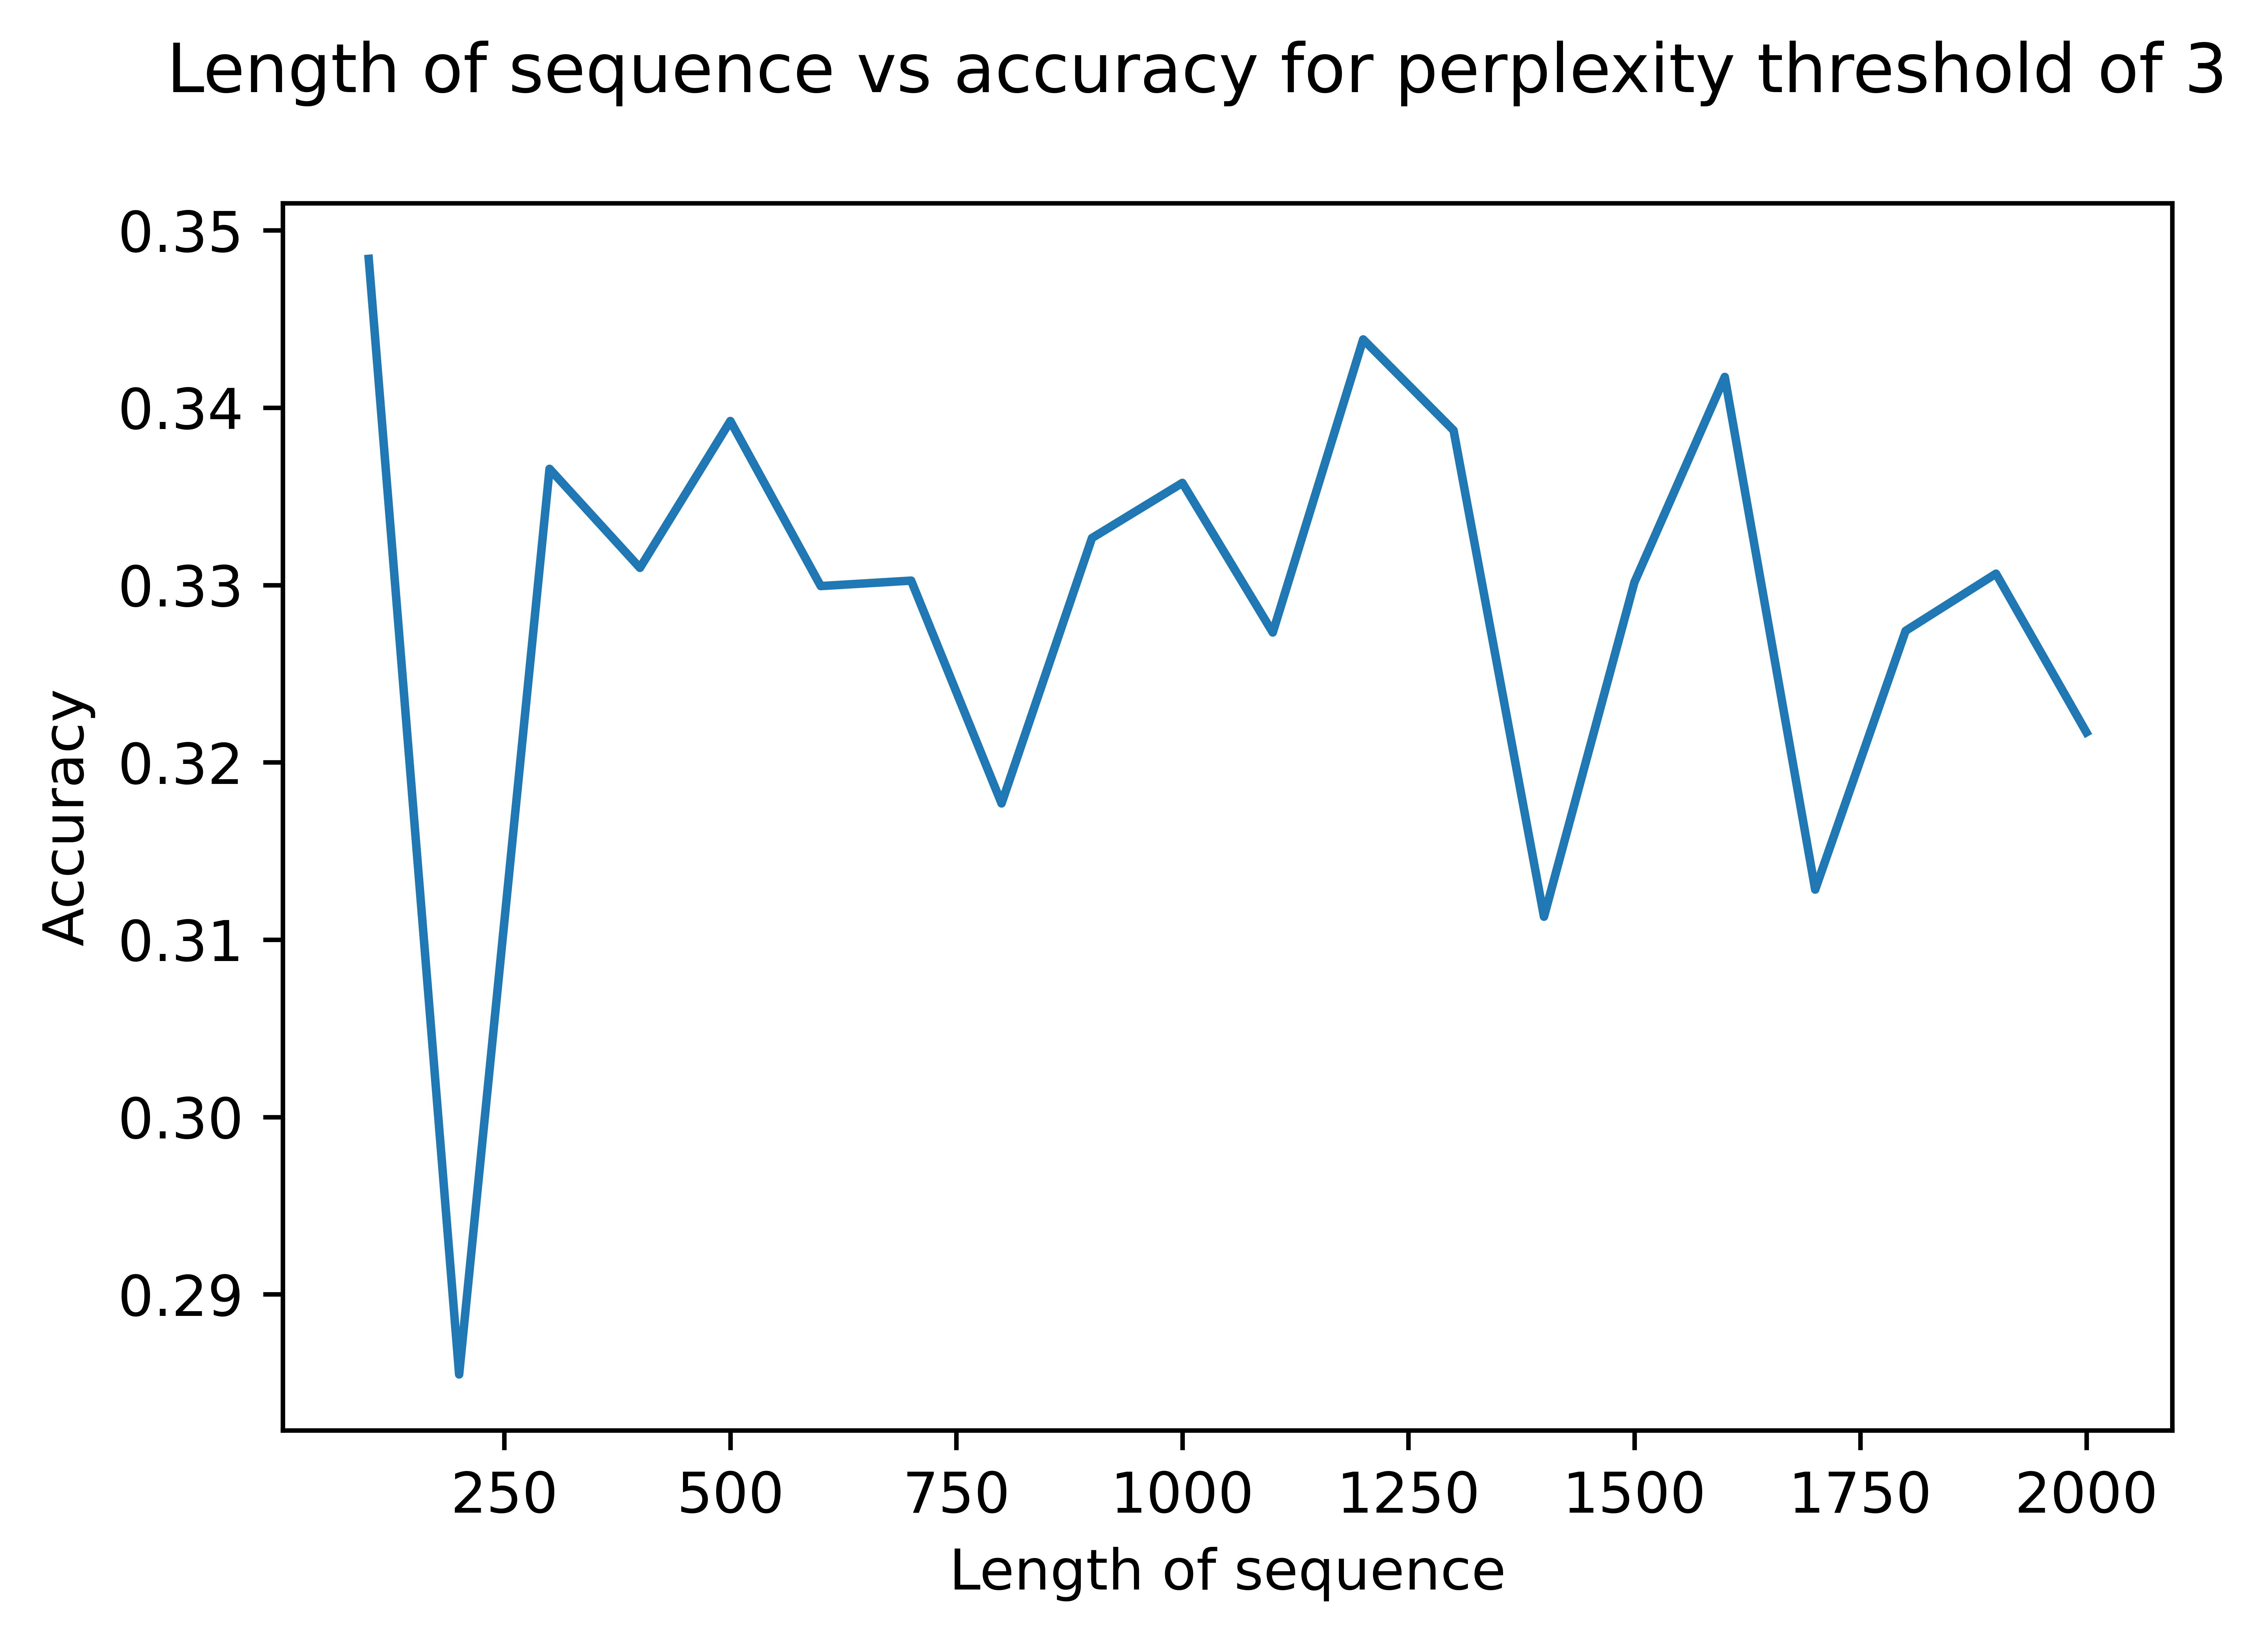

In [228]:
means3 = []
stdv3 = []

for sub in accuracies3:
    means3.append(sum(sub)/len(sub))
    stdv3.append(np.std(sub))

fig = plt.figure(dpi=1200)
plt.plot(np.arange(100,2100,100), means3)
plt.xlabel('Length of sequence')
plt.ylabel('Accuracy')
fig.suptitle('Length of sequence vs accuracy for perplexity threshold of 3')
fig.savefig('Perp3.pdf')

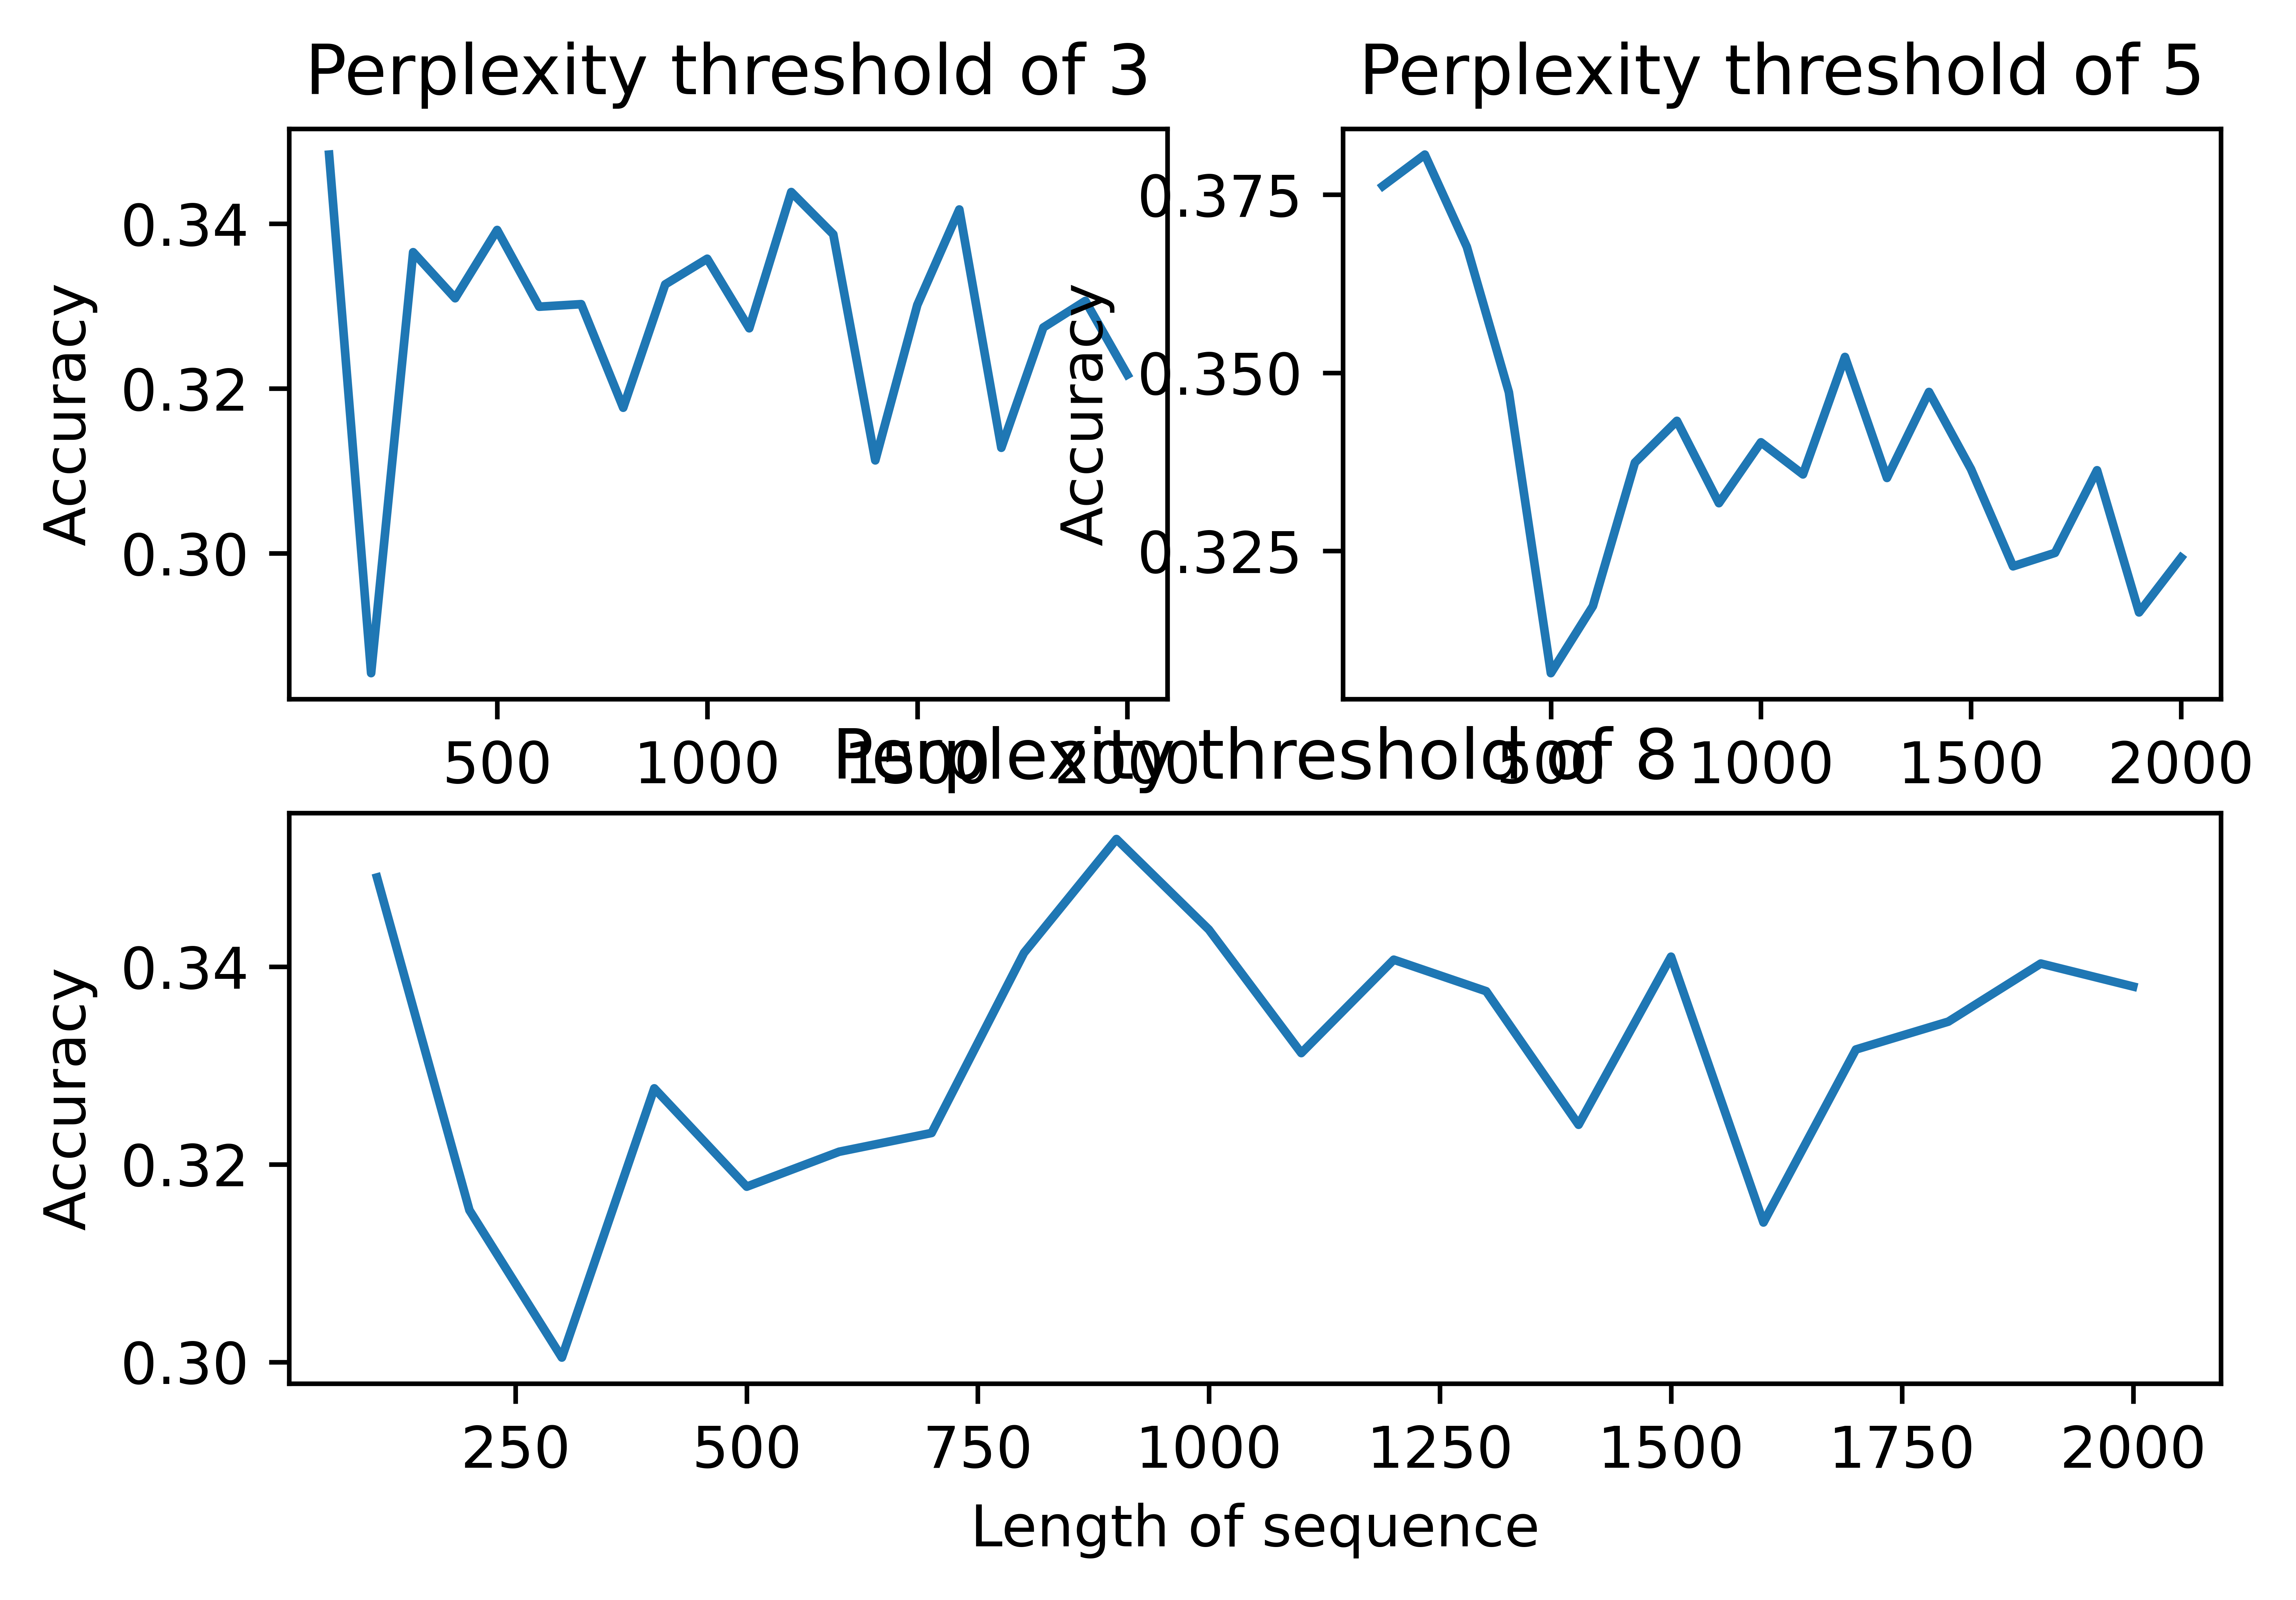

In [227]:
# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(dpi=1200)
ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
ax1.plot(np.arange(100,2100,100), means3)
ax1.set_xlabel('Length of sequence')
ax1.set_ylabel('Accuracy')
ax1.title.set_text('Perplexity threshold of 3')

ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 1
ax2.plot(np.arange(100,2100,100), means5)
ax2.set_xlabel('Length of sequence')
ax2.set_ylabel('Accuracy')
ax2.title.set_text('Perplexity threshold of 5')

ax3 = fig.add_subplot(gs[1, :]) # row 1, span all columns
ax3.plot(np.arange(100,2100,100), means8)
ax3.set_xlabel('Length of sequence')
ax3.set_ylabel('Accuracy')
ax3.title.set_text('Perplexity threshold of 8')